In [30]:
import spacy
import pandas as pd
import fr_core_news_lg
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook

In [2]:
df = pd.read_csv('french_10.csv')

In [3]:
df.head(5)

,_id,url,date,text,title
0,5ec760320e5c92500d004aec,https://plus.lesoir.be/302284/article/2020-05-...,2020-05-22T04:49:17.000Z,"Jamal Khashoggi, critique du régime saoudien a...",La famille du journaliste saoudien tué dans le...
1,5ec760320e5c92500d004aed,https://plus.lesoir.be/302283/article/2020-05-...,2020-05-22T04:32:51.000Z,Coronavirus: plus de 1.200 nouveaux morts aux ...,Coronavirus: plus de 1.200 nouveaux morts aux ...
2,5ec760320e5c92500d004aee,https://plus.lesoir.be/302282/article/2020-05-...,2020-05-22T04:22:52.000Z,Les concentrations de différents polluants rel...,La qualité de l’air en nette amélioration à Br...
3,5ec76032039b233f9642aeb2,https://plus.lesoir.be/302232/article/2020-05-...,2020-05-22T04:00:00.000Z,Vous avez aimé la bataille hivernale entre les...,Open VLD: une élection présidentielle à coutea...
4,5ec760320e5c92500d004aef,https://plus.lesoir.be/302281/article/2020-05-...,2020-05-22T04:17:10.000Z,Le premier facteur demeure le salaire. Plus d’...,Six ménages sur dix ont perdu de l’argent dura...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     10000 non-null  object
 1   url     10000 non-null  object
 2   date    10000 non-null  object
 3   text    9945 non-null   object
 4   title   9997 non-null   object
dtypes: object(5)
memory usage: 390.8+ KB


In [6]:
df['text'] = df['text'].astype(str)

In [7]:
# SpaCy model:
nlp = fr_core_news_lg.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [8]:
df['tokens'] = tokens
df['tokens']

0       [jamal, khashoggi, critique, régime, saoudien,...
1       [coronavirus, nouveau, mort, trump, mettre, dr...
2       [concentration, polluant, relever, mars, mai, ...
3       [avoir, aimer, bataille, hivernal, libéral, fr...
4       [facteur, demeure, salaire, tiers, ménage, ind...
                              ...                        
9995    [discussion, gouvernement, belge, lufthansa, p...
9996    [fond, crise, sanitaire, économique, lier, pan...
9997    [enseigne, bruxellois, meuble, contemporain, a...
9998    [compte, accès, trouver, compte, donner, accès...
9999    [birmanie, soumettre, rapport, mesure, prendre...
Name: tokens, Length: 10000, dtype: object

Create dictionary and corpus

In [11]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [13]:
print(dictionary)

Dictionary<41335 unique tokens: ['ancien', 'annoncer', 'arabie', 'assassiner', 'consulat']...>


In [14]:
#some of the IDs assigned to the tokens
print(dictionary.token2id)

{'ancien': 0, 'annoncer': 1, 'arabie': 2, 'assassiner': 3, 'consulat': 4, 'corps': 5, 'critique': 6, 'document': 7, 'découper': 8, 'enfant': 9, 'fils': 10, 'istanbul': 11, 'jamal': 12, 'journaliste': 13, 'khashoggi': 14, 'martyr': 15, 'meurtre': 16, 'morceau': 17, 'octobre': 18, 'pardonner': 19, 'père': 20, 'rendre': 21, 'récupérer': 22, 'régime': 23, 'salah': 24, 'saoudien': 25, 'saoudite': 26, 'tuer': 27, 'tueur': 28, 'twitter': 29, 'vendredi': 30, 'washington': 31, 'écrire': 32, 'être': 33, 'américain': 34, 'berne': 35, 'bâtiment': 36, 'cause': 37, 'comptage': 38, 'continu': 39, 'coronavirus': 40, 'dernier': 41, 'drapeau': 42, 'décès': 43, 'endeuiller': 44, 'enregistrer': 45, 'flottant': 46, 'fédéral': 47, 'heure': 48, 'honorer': 49, 'hopkins': 50, 'jeudi': 51, 'johns': 52, 'jour': 53, 'lier': 54, 'mettre': 55, 'mise': 56, 'monument': 57, 'mort': 58, 'mémoire': 59, 'national': 60, 'nouveau': 61, 'pays': 62, 'perdre': 63, 'prochain': 64, 'président': 65, 'référence': 66, 'soir': 67, 

In [15]:
#filter out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [16]:
#construct the corpus using the dictionary from above and the doc2bow function.
#The function doc2bow() simply counts the number of occurrences of each distinct word,
#converts the word to its integer word id and returns the result as a sparse vector
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

Model building

In [18]:
#train the unsupervised machine learning model on the data. 
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

Calculating the coherence score using C_umass

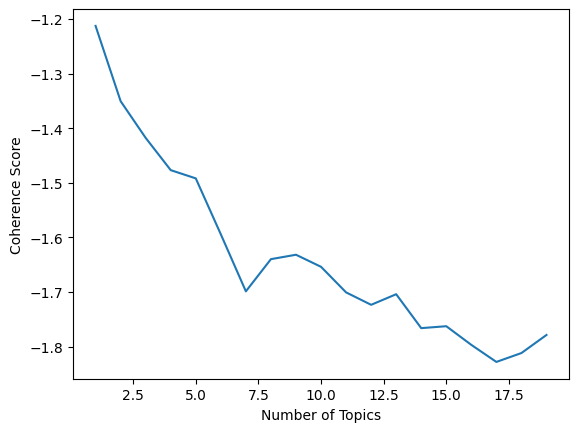

In [23]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Calculating the coherence score using C_v

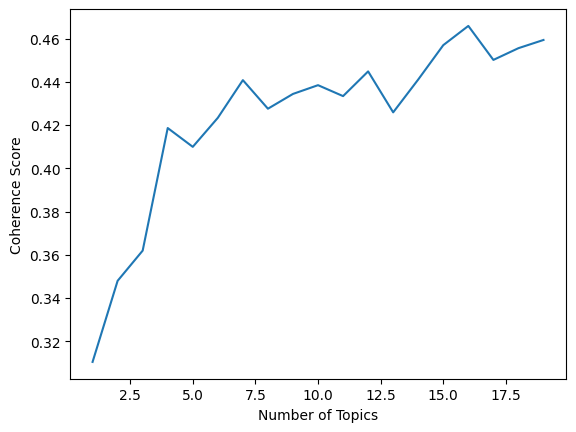

In [24]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

When looking at the coherence using the C_umass or C_v algorithm, the best is usually the max. Looking at the graphs I choose to go with 6 topics.

Optimal model

In [26]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=6, workers = 4, passes=100)

Print and visualize topics

In [27]:
lda_model.print_topics(-1)

[(0,
  '0.015*"an" + 0.014*"club" + 0.013*"saison" + 0.010*"dernier" + 0.010*"grand" + 0.009*"faire" + 0.009*"joueur" + 0.008*"année" + 0.007*"devoir" + 0.007*"monde"'),
 (1,
  '0.026*"cas" + 0.026*"pays" + 0.022*"coronavirus" + 0.016*"mort" + 0.014*"personne" + 0.014*"pandémie" + 0.014*"décès" + 0.013*"nouveau" + 0.013*"nombre" + 0.011*"samedi"'),
 (2,
  '0.014*"crise" + 0.012*"euro" + 0.011*"entreprise" + 0.010*"million" + 0.008*"mois" + 0.007*"faire" + 0.006*"année" + 0.006*"devoir" + 0.006*"secteur" + 0.006*"mettre"'),
 (3,
  '0.023*"ministre" + 0.020*"gouvernement" + 0.017*"président" + 0.013*"pouvoir" + 0.012*"parti" + 0.011*"politique" + 0.010*"pays" + 0.009*"reprise" + 0.008*"fédéral" + 0.008*"annoncer"'),
 (4,
  '0.017*"police" + 0.017*"an" + 0.012*"homme" + 0.010*"femme" + 0.009*"dimanche" + 0.009*"personne" + 0.009*"compte" + 0.008*"rue" + 0.008*"jeune" + 0.007*"trouver"'),
 (5,
  '0.014*"pouvoir" + 0.013*"masque" + 0.011*"enfant" + 0.010*"mesure" + 0.010*"faire" + 0.009*"éc

Where does a text belong to

In [28]:
df['text'][0]

'Jamal Khashoggi, critique du régime saoudien après en avoir été proche, a été assassiné et son corps découpé en morceaux le 2 octobre 2018\\n\\nLes enfants de Jamal Khashoggi, journaliste saoudien assassiné en octobre 2018 dans le consulat d’Arabie saoudite à Istanbul, ont annoncé vendredi qu’ils pardonnaient aux tueurs de leur père.\\n\\n« Nous, les fils du martyr Jamal Khashoggi, annonçons que nous pardonnons à ceux qui ont tué notre père », a écrit sur Twitter Salah Khashoggi, fils de l’ancien journaliste du Washington Post.\\n\\nUn meurtre odieux\\n\\nJamal Khashoggi, critique du régime saoudien après en avoir été proche, a été assassiné et son corps découpé en morceaux le 2 octobre 2018 dans le consulat d’Arabie saoudite à Istanbul où il s’était rendu pour récupérer un document.'

In [29]:
lda_model[corpus][0]

[(0, 0.16705516), (4, 0.8024689)]

In [ ]:
#According to our LDA model, the above text belongs to Topic 0 and 4.
#The article is 80% belonging to topic 4 (index 3) and 16% belonging to topic 0 (index 1).

Visualization

In [31]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [ ]:
#path = os.path.join('.results')

In [ ]:
#with open(path, 'wb') as f:
    #pickle.dump(LDAvis,f)

#with open(path, 'rb') as f:
    #LDAvis = pickle.load(f)

#pyLDAvis.save_html(LDAvis, './results' + '_spacy' + '.html')